In [1]:
moviedb_api_key = "8e19741f71605c762cad76ed2d1c67cb"

In [2]:
import requests
import json
moviedb_base_url = "https://api.themoviedb.org/3/movie"
moviedb_api_key = "8e19741f71605c762cad76ed2d1c67cb"
def get_movie_info(movie_id):
    movie_response = requests.get(f"{moviedb_base_url}/{movie_id}?api_key={moviedb_api_key}")
    return json.loads(movie_response.text)

In [3]:
print(get_movie_info(88))

{'adult': False, 'backdrop_path': '/6iDQCBUSZKzY8Rnu8ECwl2gXcfG.jpg', 'belongs_to_collection': {'id': 86058, 'name': 'Dirty Dancing Collection', 'poster_path': '/gkrOvdbCFuGlxVwCYmczw7aw6Ku.jpg', 'backdrop_path': '/qR6POAKwCL8VwuK8ZjSAdRRFNj9.jpg'}, 'budget': 6000000, 'genres': [{'id': 18, 'name': 'Drama'}, {'id': 10402, 'name': 'Music'}, {'id': 10749, 'name': 'Romance'}], 'homepage': 'http://lionsgateathome.com/dirty-dancing', 'id': 88, 'imdb_id': 'tt0092890', 'origin_country': ['US'], 'original_language': 'en', 'original_title': 'Dirty Dancing', 'overview': "Expecting the usual tedium that accompanies a summer in the Catskills with her family, 17-year-old Frances 'Baby' Houseman is surprised to find herself stepping into the shoes of a professional hoofer—and unexpectedly falling in love.", 'popularity': 13.9893, 'poster_path': '/9Jw6jys7q9gjzVX5zm1z0gC8gY9.jpg', 'production_companies': [{'id': 137, 'logo_path': None, 'name': 'Great American Films Limited Partnership', 'origin_countr

In [4]:
##Para que se vea mejor la estructura de datos
movie_id_prueba = input("id de la pelicula")
movie_response = requests.get(f"{moviedb_base_url}/{movie_id_prueba}?api_key={moviedb_api_key}")
movie_json = json.loads(movie_response.text)
for key, value in movie_json.items():
    print(key,":",value)

id de la pelicula toy story


success : False
status_code : 6
status_message : Invalid id: The pre-requisite id is invalid or not found.


In [5]:
import os
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import time

##Extracción
N = 1500 #Número de películas a descargar
movie_ids = random.sample(range(1, 900000), N)
movies_raw =[]

for movie_id in tqdm(movie_ids):
    try:
        data = get_movie_info(movie_id)
        if data is not None:
            movies_raw.append(data)
    except Exception as e:
        print(f"Error en ID {movie_id}:{e}")
    time.sleep(0.2) #Delay para evitar muchas peticiones seguidas a TMDB

def clean_movie_data(movie):
    return {
        "id": movie.get("id"),
        "title": movie.get("title"),
        "original_title": movie.get("original_title"),
        "overview": movie.get("overview"),
        "release_date": movie.get("release_date"),
        "year": int(movie["release_date"][:4]) if movie.get("release_date") else None,
        "budget": movie.get("budget"),
        "revenue": movie.get("revenue"),
        "profit": movie.get("revenue", 0) - movie.get("budget",0),
        "runtime": movie.get("runtime"),
        "popularity": movie.get("popularity"),
        "vote_average": movie.get("vote_average"),
        "vote_count": movie.get("vote_count"),
        "genres":",".join(g["name"] for g in movie.get("genres",[])),
        "production_companies":",".join([c["name"] for c in movie.get("production_companies",[])]),
        "production_countries":",".join([c["name"] for c in movie.get("production_countries",[])]),
        "spoken_languages":",".join([l["name"] for l in movie.get("spoken_languages",[])]),
        }
clean_data = [clean_movie_data(m) for m in movies_raw]
df = pd.DataFrame(clean_data)

100%|██████████| 1500/1500 [06:40<00:00,  3.74it/s]


In [6]:
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")

numeric_columns = ["budget", "revenue", "profit", "runtime", "popularity", "vote_average", "vote_count"]
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors = "coerce")

df.replace(["", " ", "-", "null"], np.nan, inplace = True) #Reemplaza valores vacios

df.drop_duplicates(subset="id", inplace = True) #Elimina duplicados

df.info()
df.head()
os.makedirs("data", exist_ok = True)
df.to_csv("data/moviees_clean.csv", index = True)

print("Dataset exportado: data/movies_clean.csv")

<class 'pandas.core.frame.DataFrame'>
Index: 1131 entries, 0 to 1499
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    1130 non-null   float64       
 1   title                 1130 non-null   object        
 2   original_title        1130 non-null   object        
 3   overview              991 non-null    object        
 4   release_date          1075 non-null   datetime64[ns]
 5   year                  1075 non-null   float64       
 6   budget                1130 non-null   float64       
 7   revenue               1130 non-null   float64       
 8   profit                1131 non-null   int64         
 9   runtime               1130 non-null   float64       
 10  popularity            1130 non-null   float64       
 11  vote_average          1130 non-null   float64       
 12  vote_count            1130 non-null   float64       
 13  genres                8

In [7]:
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

sns.set(style="whitegrid")  

_possible_names = ['df', 'movies', 'movies_df', 'df_movies', 'movies_clean', 'tmdb', 'df_tmdb']
movie_df = None
g = globals()
for name in _possible_names:
    if name in g and isinstance(g[name], pd.DataFrame):
        movie_df = g[name]
        print(f"Usando DataFrame existente en variable '{name}'.")
        break

if movie_df is None:
    path = '/mnt/data/moviees_clean.csv'
    print(f"No se encontró DataFrame en memoria. Cargando CSV desde: {path}")
    movie_df = pd.read_csv(path)

df = movie_df.copy()

Usando DataFrame existente en variable 'df'.


In [8]:
def best_col(*candidates):
    """Retorna el primer nombre de columna presente en df entre candidates."""
    for c in candidates:
        if c in df.columns:
            return c
    return None

col_title = best_col('title','name','original_title')
col_budget = best_col('budget','budget_amount')
col_revenue = best_col('revenue','gross','box_office')
col_vote = best_col('vote_average','vote_mean','rating','vote')
col_pop = best_col('popularity','popularity_score')
col_runtime = best_col('runtime','duration','runtime_minutes','length')
col_release_date = best_col('release_date','release_date.x','date','released')
col_release_year = best_col('release_year','year','release_year_int')
col_genres = best_col('genres','genre','genres_names','genre_names','movie_genres')
col_prod_comp = best_col('production_companies','production_company','company','production_companies_list')

In [9]:
if col_release_year is None and col_release_date is not None:
    try:
        df['_release_date_parsed'] = pd.to_datetime(df[col_release_date], errors='coerce')
        df['release_year'] = df['_release_date_parsed'].dt.year
        col_release_year = 'release_year'
    except Exception:
        df['release_year'] = np.nan
        col_release_year = 'release_year'
elif col_release_year is None:
    df['release_year'] = np.nan
    col_release_year = 'release_year'

In [10]:
def parse_genres_cell(x):
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return [str(i).strip() for i in x if i]
    if isinstance(x, str):
        s = x.strip()
        if s.startswith('[') and s.endswith(']'):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, list):
                    return [str(i).strip() for i in parsed if i]
            except Exception:
                pass
        if '|' in s:
            return [p.strip() for p in s.split('|') if p.strip()]
        if ',' in s:
            return [p.strip() for p in s.split(',') if p.strip()]
        if s.startswith('{') or s.startswith('['):
            try:
                parsed = ast.literal_eval(s)
                if isinstance(parsed, list):
                    names = []
                    for item in parsed:
                        if isinstance(item, dict):
                            name = item.get('name') or item.get('title') or item.get('genre')
                            if name:
                                names.append(str(name).strip())
                    if names:
                        return names
            except Exception:
                pass
        maybe = re.findall(r"[A-Z][a-zA-Z& ]{1,20}", s)
        if maybe:
            return [m.strip() for m in maybe]
        return [s]
    return []

In [11]:
if col_genres is not None:
    df['_genres_list'] = df[col_genres].apply(parse_genres_cell)
else:
    df['_genres_list'] = [[] for _ in range(len(df))]

df_genres_exploded = df.explode('_genres_list').rename(columns={'_genres_list':'genre'})
df_genres_exploded['genre'] = df_genres_exploded['genre'].astype(str).replace('nan','').replace('', np.nan)

In [12]:
def to_numeric_safe(col):
    if col is None:
        return pd.Series([np.nan]*len(df))
    s = pd.to_numeric(df[col], errors='coerce')
    return s

df['_budget_num'] = to_numeric_safe(col_budget)
df['_revenue_num'] = to_numeric_safe(col_revenue)
df['_vote_num'] = to_numeric_safe(col_vote)
df['_popularity_num'] = to_numeric_safe(col_pop)
df['_runtime_num'] = to_numeric_safe(col_runtime)

In [13]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1131 entries, 0 to 1499
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    1130 non-null   float64       
 1   title                 1130 non-null   object        
 2   original_title        1130 non-null   object        
 3   overview              991 non-null    object        
 4   release_date          1075 non-null   datetime64[ns]
 5   year                  1075 non-null   float64       
 6   budget                1130 non-null   float64       
 7   revenue               1130 non-null   float64       
 8   profit                1131 non-null   int64         
 9   runtime               1130 non-null   float64       
 10  popularity            1130 non-null   float64       
 11  vote_average          1130 non-null   float64       
 12  vote_count            1130 non-null   float64       
 13  genres                8

In [14]:
movie_df.head()

,id,title,original_title,overview,release_date,year,budget,revenue,profit,runtime,popularity,vote_average,vote_count,genres,production_companies,production_countries,spoken_languages
0,16113.0,The Delta Force,The Delta Force,"A 707 aircraft jetliner, en route from Athens ...",1986-02-14,1986.0,9000000.0,17768900.0,8768900,129.0,4.9857,6.0,465.0,"Action,Thriller,Adventure,War","The Cannon Group,Golan-Globus Productions",United States of America,"العربية,English,ελληνικά"
1,745670.0,While You Were Sleeping,While You Were Sleeping,NaN,2019-07-22,2019.0,0.0,0.0,0,0.0,0.0168,0.0,0.0,NaN,NaN,NaN,English
2,442029.0,When They Say You're Alone,When They Say You're Alone,A woman is watched as she sleeps by a cult of ...,2014-10-21,2014.0,0.0,0.0,0,4.0,0.7010,4.0,1.0,Horror,NaN,United States of America,NaN
3,676360.0,Inez & Doug & Kira,Inez & Doug & Kira,"When a bipolar woman commits suicide, her sist...",2019-10-05,2019.0,0.0,0.0,0,96.0,1.7886,5.0,3.0,"Drama,Mystery",NaN,United States of America,English
4,30487.0,Greedy Mouth,Bocca golosa,NaN,1981-04-23,1981.0,0.0,0.0,0,0.0,0.0000,8.0,3.0,NaN,Cinema 80,Italy,Italiano


In [15]:
# 1 ¿Cuántas películas hay en el dataset? 
n_peliculas = len(df)
print(f"1) Número total de películas: {n_peliculas}")

1) Número total de películas: 1131


In [16]:
# 2. Película con mayor presupuesto
if col_title and df['_budget_num'].notna().any():
    idx = df['_budget_num'].idxmax()
    mayor_presupuesto = (df.loc[idx, col_title], df.loc[idx, '_budget_num'])
else:
    mayor_presupuesto = (None, np.nan)
print(f"2) Película con mayor presupuesto: {mayor_presupuesto}")

2) Película con mayor presupuesto: ('Missing Link', 100000000.0)


In [17]:
# 3. Película con mayor recaudación
if col_title and df['_revenue_num'].notna().any():
    idx = df['_revenue_num'].idxmax()
    mayor_recaudacion = (df.loc[idx, col_title], df.loc[idx, '_revenue_num'])
else:
    mayor_recaudacion = (None, np.nan)
print(f"3) Película con mayor recaudación: {mayor_recaudacion}")

3) Película con mayor recaudación: ('High School Musical 3: Senior Year', 252909177.0)


In [18]:
# 4. Película con mejor media de votos
if col_title and df['_vote_num'].notna().any():
    idx = df['_vote_num'].idxmax()
    mejor_media_votos = (df.loc[idx, col_title], df.loc[idx, '_vote_num'])
else:
    mejor_media_votos = (None, np.nan)
print(f"4) Película con mejor media de votos: {mejor_media_votos}")

4) Película con mejor media de votos: ('Classic Steam Train Collection: Black Five', 10.0)


In [19]:
# 5. Película con menor popularidad
if col_title and df['_popularity_num'].notna().any():
    idx = df['_popularity_num'].idxmin()
    menor_popularidad = (df.loc[idx, col_title], df.loc[idx, '_popularity_num'])
else:
    menor_popularidad = (None, np.nan)
print(f"5) Película con menor popularidad: {menor_popularidad}")

5) Película con menor popularidad: ('Greedy Mouth', 0.0)


In [20]:
# 6. ¿Cuántas películas tiene cada género?
genre_counts = df_genres_exploded['genre'].value_counts(dropna=True)
print("6) Número de películas por género (top):")
print(genre_counts.head(20))

6) Número de películas por género (top):
genre
Drama              298
Documentary        193
Comedy             177
Thriller            74
Romance             69
Animation           66
Music               65
Action              64
Horror              61
Crime               45
Family              38
Adventure           37
Science Fiction     30
TV Movie            30
Fantasy             24
History             19
Mystery             18
War                 18
Western             15
Name: count, dtype: int64


In [21]:
# 7. Duración media
runtime_mean = df['_runtime_num'].dropna().mean()
print(f"7) Duración media de las películas (minutos): {runtime_mean:.2f}")

7) Duración media de las películas (minutos): 57.03


In [22]:
# 8. Año con más películas
if col_release_year is not None:
    year_counts = df[col_release_year].value_counts(dropna=True).sort_values(ascending=False)
    top_year = (year_counts.index[0], int(year_counts.iloc[0])) if len(year_counts)>0 and not pd.isna(year_counts.index[0]) else (None, 0)
else:
    top_year = (None, 0)
print(f"8) Año con más estrenos: {top_year}")

8) Año con más estrenos: (2017.0, 57)


In [23]:
# 9. Película con mejor ROI 
df['_roi'] = np.where(df['_budget_num']>0, df['_revenue_num'] / df['_budget_num'], np.nan)
if col_title and df['_roi'].notna().any():
    idx = df['_roi'].idxmax()
    mejor_roi = (df.loc[idx, col_title], df.loc[idx, '_roi'])
else:
    mejor_roi = (None, np.nan)
print(f"9) Película con mejor ROI: {mejor_roi}")

9) Película con mejor ROI: ('High School Musical 3: Senior Year', 22.991743363636363)


In [24]:
# 10. Géneros con mayor presupuesto medio
budget_by_genre = df_genres_exploded.groupby('genre')['budget'].mean().sort_values(ascending=False)
print("10) Presupuesto medio por género (top 10):")
print(budget_by_genre.head(10))

10) Presupuesto medio por género (top 10):
genre
Mystery            7.579444e+06
Family             3.921053e+06
Adventure          3.824405e+06
Fantasy            2.354292e+06
Action             2.327917e+06
Thriller           2.084205e+06
Animation          1.969697e+06
War                1.555650e+06
Science Fiction    1.378503e+06
Romance            1.000458e+06
Name: budget, dtype: float64


In [25]:
# 11. Géneros con mayor media de votos
vote_by_genre = df_genres_exploded.groupby('genre')['vote_average'].mean().sort_values(ascending=False)
print("11) Media de votos por género (top 10):")
print(vote_by_genre.head(10))

11) Media de votos por género (top 10):
genre
Adventure          5.256459
Romance            4.780913
Action             4.641516
Science Fiction    4.369500
Comedy             4.317977
Family             4.238737
Fantasy            4.189917
Thriller           4.069730
Mystery            4.031278
TV Movie           3.969333
Name: vote_average, dtype: float64


In [26]:
# 12. Género con ingresos totales más altos
revenue_by_genre = df_genres_exploded.groupby('genre')['revenue'].sum().sort_values(ascending=False)
print("12) Recaudación total por género (top 10):")
print(revenue_by_genre.head(10))

12) Recaudación total por género (top 10):
genre
Drama       602214501.0
Thriller    467581294.0
Action      399359139.0
Comedy      359604559.0
Family      356279270.0
Mystery     323334076.0
Romance     322930374.0
Music       252909177.0
Horror      226366347.0
Fantasy     122301607.0
Name: revenue, dtype: float64


In [27]:
# 13. Correlación presupuesto ↔ recaudación
corr_budget_revenue = df[['budget','revenue']].corr().iloc[0,1]
print(f"13) Correlación entre presupuesto y recaudación: {corr_budget_revenue:.4f}")

13) Correlación entre presupuesto y recaudación: 0.5729


In [28]:
# 14. Correlación popularidad ↔ voto medio
corr_pop_vote = df[['popularity','vote_average']].corr().iloc[0,1]
print(f"14) Correlación entre popularidad y nota media: {corr_pop_vote:.4f}")

14) Correlación entre popularidad y nota media: 0.2776


In [29]:
# 15. Duración media por género
runtime_by_genre = df_genres_exploded.groupby('genre')['runtime'].mean().sort_values(ascending=False)
print("15) Duración media por género (top 10):")
print(runtime_by_genre.head(10))

15) Duración media por género (top 10):
genre
War         91.388889
Romance     84.927536
History     84.842105
Thriller    82.000000
Mystery     77.555556
Action      77.046875
Horror      76.229508
Western     73.933333
Drama       73.808725
Fantasy     73.500000
Name: runtime, dtype: float64


In [48]:
# 16. Promedio de votos por año de estreno
year_col = "year"
vote_col = "vote_average"

df_year_votes = df[[year_col, vote_col]].dropna()

avg_votes_by_year = df_year_votes.groupby(year_col)[vote_col].mean().sort_index()

print("16) Promedio de puntuación por año:")
print(avg_votes_by_year)

16) Promedio de puntuación por año:
year
1896.0    2.850000
1900.0    4.800000
1905.0    4.000000
1906.0    0.000000
1907.0    0.000000
            ...   
2020.0    2.761375
2021.0    2.954000
2022.0    5.122167
2023.0    5.400000
2024.0    0.000000
Name: vote_average, Length: 117, dtype: float64


In [31]:
# 17. Peor ROI
if col_title and df['_roi'].notna().any():
    idx = df['_roi'].idxmin()
    peor_roi = (df.loc[idx, col_title], df.loc[idx, '_roi'])
else:
    peor_roi = (None, np.nan)
print(f"17) Película con peor ROI: {peor_roi}")

17) Película con peor ROI: ('Ricky Rebel: Rebels Only', 0.0)


In [32]:
# 18. Top 10 películas más populares con géneros
df['genres_list'] = df['genres'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
df_exploded = df.explode('genres_list')
top10_pop = df.sort_values('popularity', ascending=False).head(10)
top10_pop_titles_genres = top10_pop[[col_title, 'popularity', 'genres_list']]
print(top10_pop_titles_genres)

                                                  title  popularity  \
1160                                    Pan's Labyrinth     16.5859   
1342                           P.O.E. : Project of Evil     11.5563   
996                                   Stewardess School     11.5299   
1280                                      Beloved Enemy      8.3944   
1060                                         Love Hurts      7.5076   
1327                                      Magical River      7.1860   
1479                                          Buttoners      6.5177   
873                                               Twink      6.4886   
593                                              Nailed      6.1928   
379   L'Année des Guignols - Un Jean-Pierre ça peut ...      6.0484   

                genres_list  
1160  [Fantasy, Drama, War]  
1342               [Horror]  
996                [Comedy]  
1280       [Drama, Romance]  
1060     [Thriller, Horror]  
1327      [Comedy, Fantasy]  
1479    

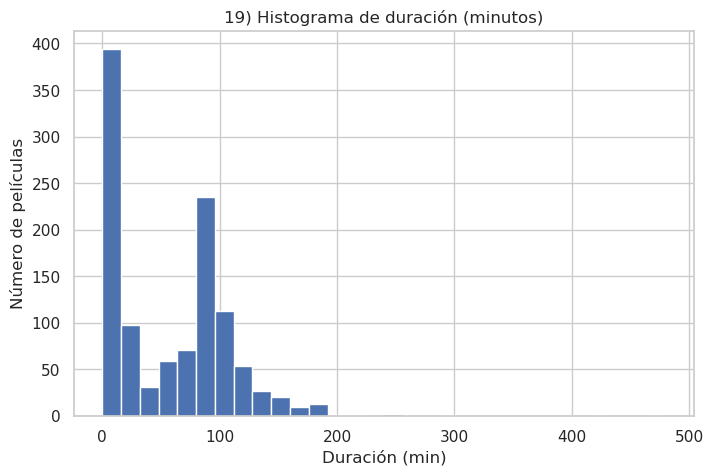

In [33]:
# 19. Histograma de duración
fig_19 = plt.figure(figsize=(8,5))
plt.hist(df['runtime'].dropna(), bins=30)
plt.title('19) Histograma de duración (minutos)')
plt.xlabel('Duración (min)')
plt.ylabel('Número de películas')
plt.grid(True)
plt.show()

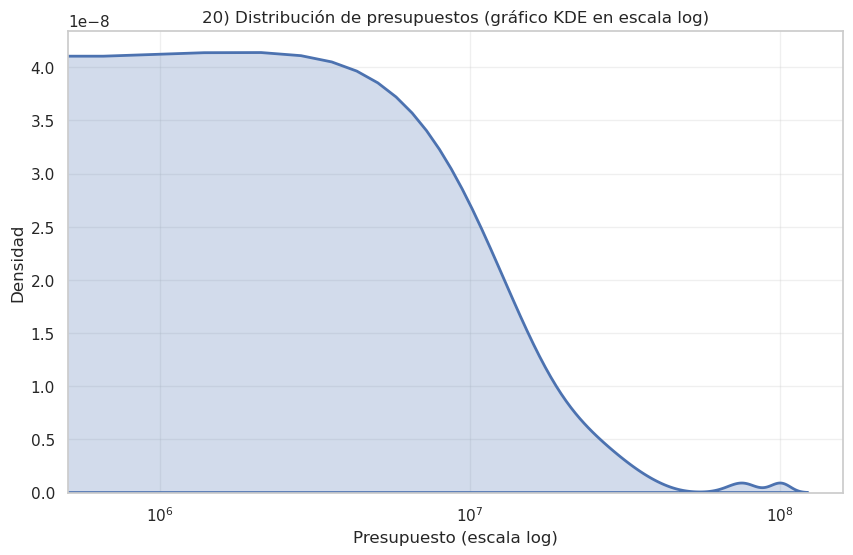

In [34]:
# 20. Histograma de presupuestos
ig_20b = plt.figure(figsize=(10,6))

presupuestos = df['_budget_num'].dropna()
presupuestos = presupuestos[presupuestos > 0]  

sns.kdeplot(presupuestos, fill=True, linewidth=2)

plt.xscale('log')  
plt.xlabel('Presupuesto (escala log)')
plt.ylabel('Densidad')
plt.title('20) Distribución de presupuestos (gráfico KDE en escala log)')
plt.grid(True, alpha=0.3)
plt.show()

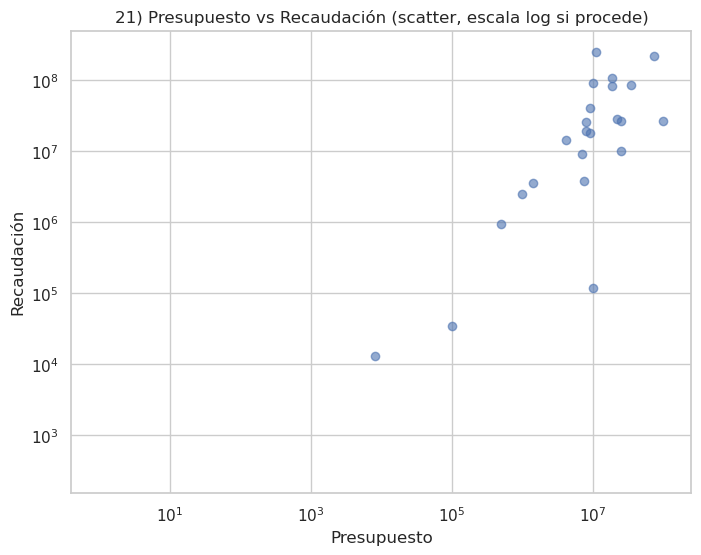

In [35]:
# 21. Scatter presupuesto vs recaudación
fig_21 = plt.figure(figsize=(8,6))
plt.scatter(df['_budget_num'], df['revenue'], alpha=0.6)
plt.xscale('log') if (df['budget']>0).any() else None
plt.yscale('log') if (df['revenue']>0).any() else None
plt.xlabel('Presupuesto')
plt.ylabel('Recaudación')
plt.title('21) Presupuesto vs Recaudación (scatter, escala log si procede)')
plt.grid(True)
plt.show()

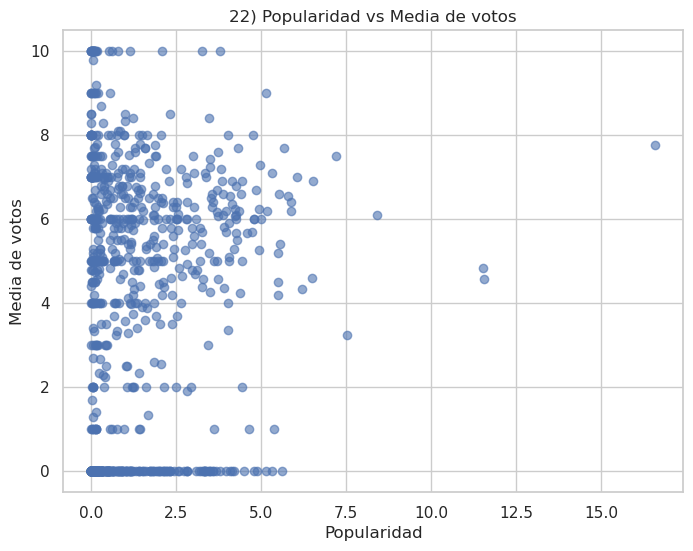

In [36]:
# 22. Scatter popularidad vs media de votos
fig_22 = plt.figure(figsize=(8,6))
plt.scatter(df['popularity'], df['vote_average'], alpha=0.6)
plt.xlabel('Popularidad')
plt.ylabel('Media de votos')
plt.title('22) Popularidad vs Media de votos')
plt.grid(True)
plt.show()

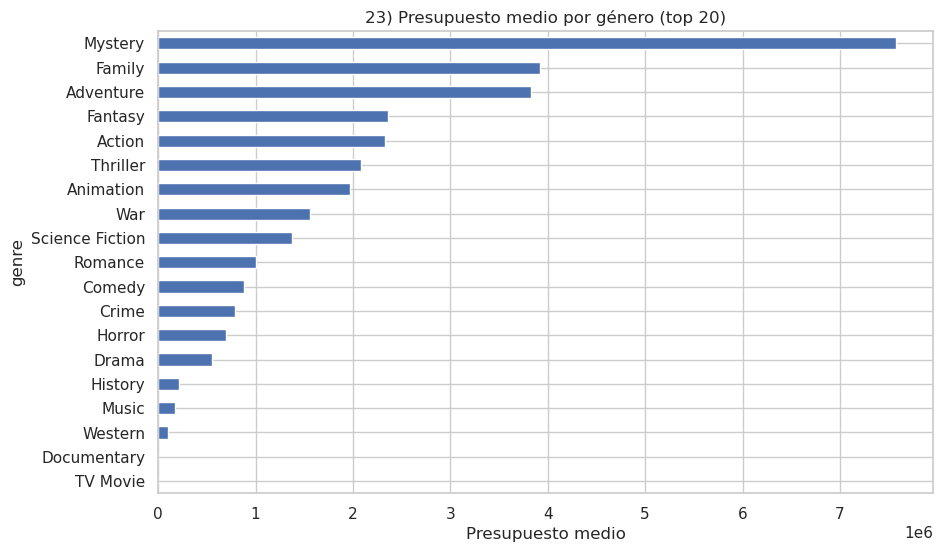

In [37]:
# 23. Barras presupuesto medio por género
fig_23 = plt.figure(figsize=(10,6))
budget_by_genre_plot = budget_by_genre.dropna().head(20)[::-1]  
budget_by_genre_plot.plot(kind='barh')
plt.xlabel('Presupuesto medio')
plt.title('23) Presupuesto medio por género (top 20)')
plt.show()

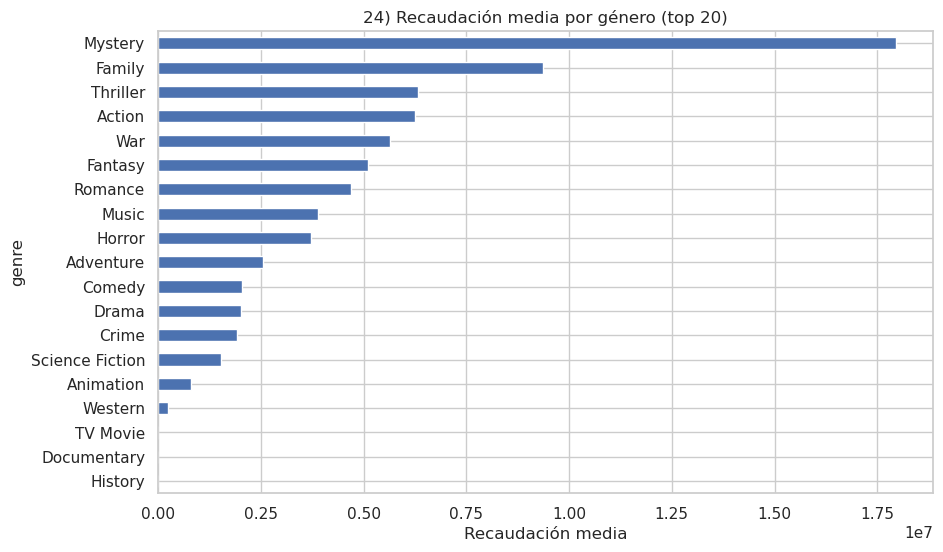

In [38]:
# 24. Barras recaudación media por género
fig_24 = plt.figure(figsize=(10,6))
revenue_mean_by_genre = df_genres_exploded.groupby('genre')['revenue'].mean().sort_values(ascending=False).head(20)[::-1]
revenue_mean_by_genre.plot(kind='barh')
plt.xlabel('Recaudación media')
plt.title('24) Recaudación media por género (top 20)')
plt.show()

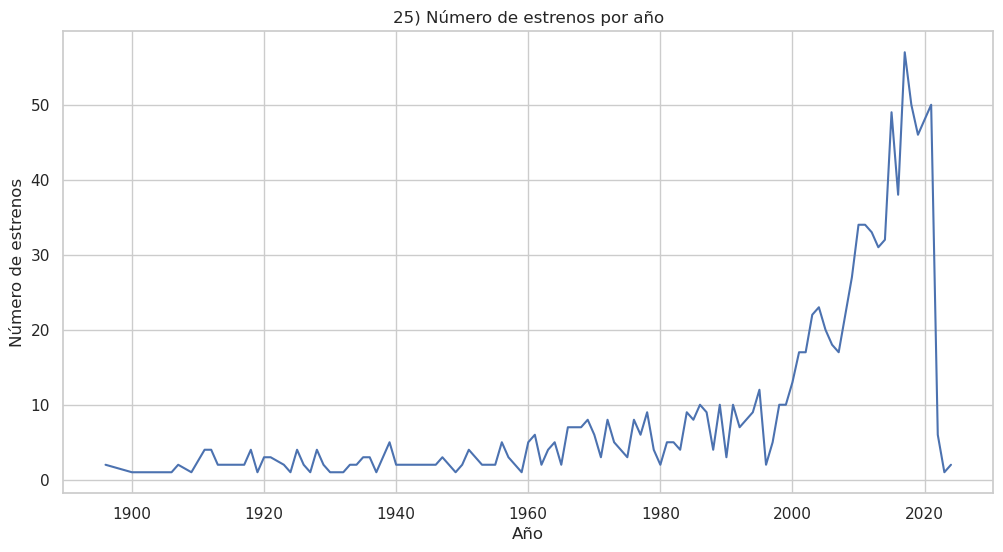

In [39]:
# 25. Línea temporal de número de películas por año
fig_25 = plt.figure(figsize=(12,6))
year_counts_sorted = df[col_release_year].value_counts().sort_index()
year_counts_sorted.plot()
plt.xlabel('Año')
plt.ylabel('Número de estrenos')
plt.title('25) Número de estrenos por año')
plt.grid(True)
plt.show()

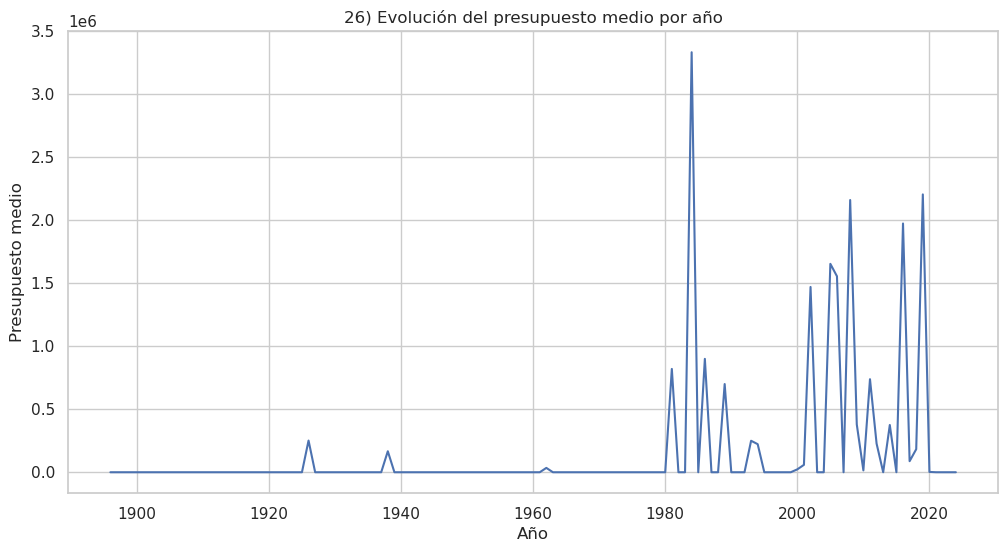

In [40]:
# 26. Presupuesto medio por año
fig_26 = plt.figure(figsize=(12,6))
budget_year = df.groupby(col_release_year)['_budget_num'].mean().sort_index()
budget_year.plot()
plt.xlabel('Año')
plt.ylabel('Presupuesto medio')
plt.title('26) Evolución del presupuesto medio por año')
plt.grid(True)
plt.show()

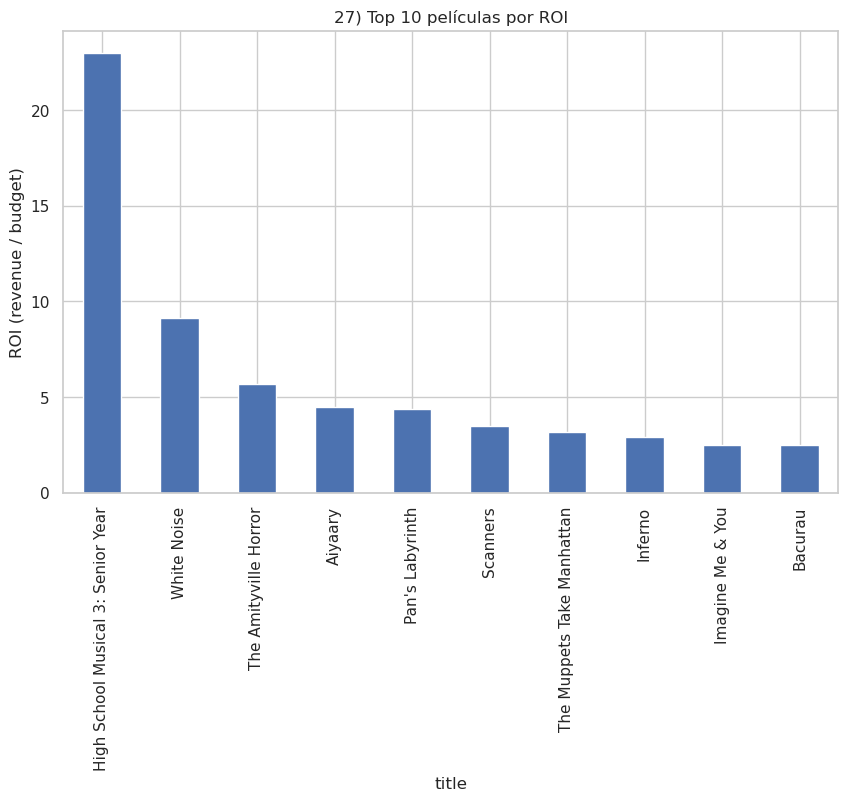

In [41]:
# 27. Top 10 películas por ROI
fig_27 = plt.figure(figsize=(10,6))
top10_roi = df.dropna(subset=['_roi']).sort_values('_roi', ascending=False).head(10).set_index(col_title)['_roi']
top10_roi.plot(kind='bar')
plt.ylabel('ROI (revenue / budget)')
plt.title('27) Top 10 películas por ROI')
plt.show()

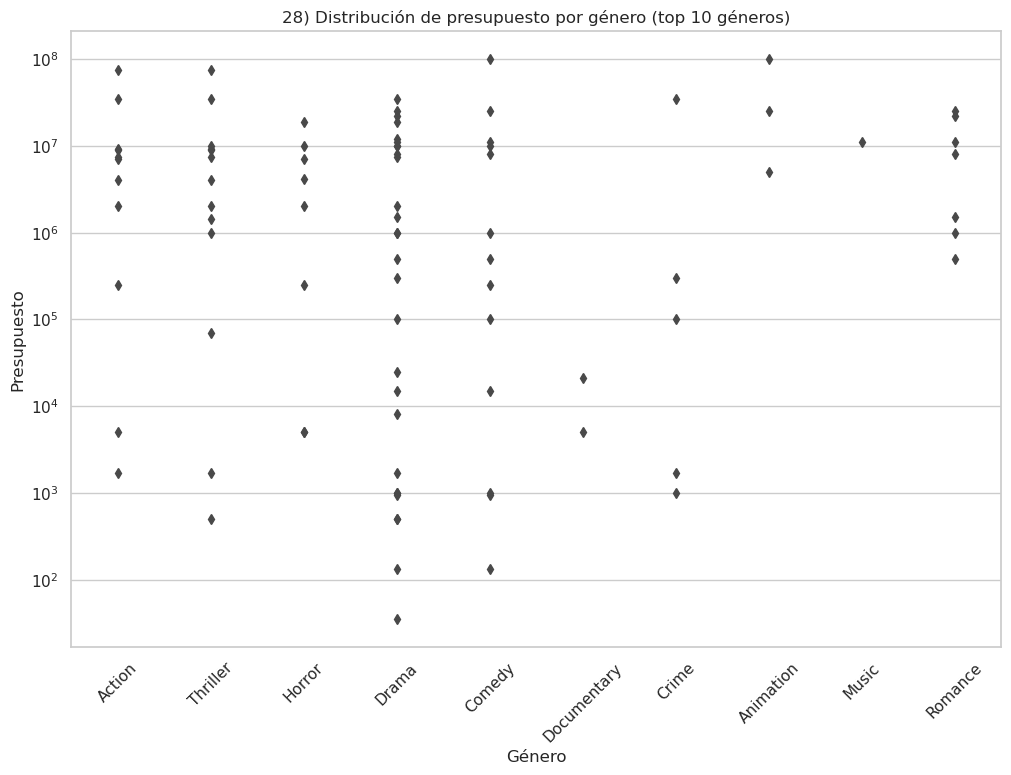

In [42]:
# 28. Boxplot presupuesto por género
ig_28 = plt.figure(figsize=(12,8))
top_genres = genre_counts.head(10).index.tolist()
boxplot_data = df_genres_exploded[df_genres_exploded['genre'].isin(top_genres)]
sns.boxplot(x='genre', y='budget', data=boxplot_data)
plt.yscale('log') if (boxplot_data['budget']>0).any() else None
plt.title('28) Distribución de presupuesto por género (top 10 géneros)')
plt.xlabel('Género')
plt.ylabel('Presupuesto')
plt.xticks(rotation=45)
plt.show()

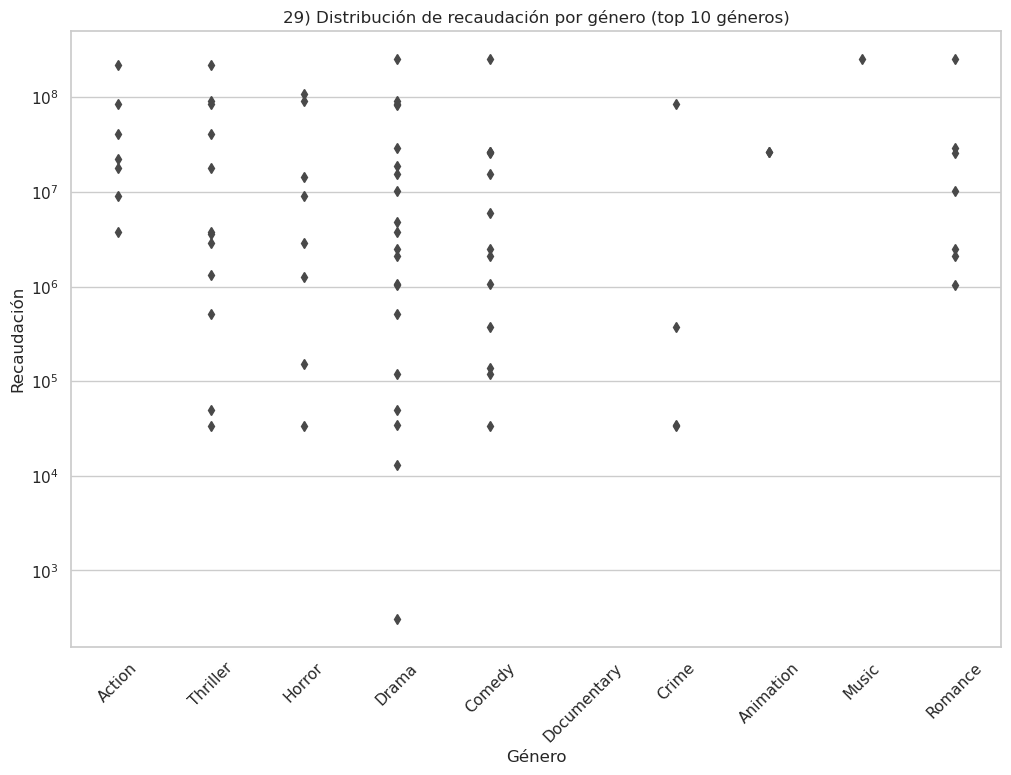

In [43]:
# 29. Boxplot recaudación por género
fig_29 = plt.figure(figsize=(12,8))
boxplot_data_rev = df_genres_exploded[df_genres_exploded['genre'].isin(top_genres)]
sns.boxplot(x='genre', y='revenue', data=boxplot_data_rev)
plt.yscale('log') if (boxplot_data_rev['revenue']>0).any() else None
plt.title('29) Distribución de recaudación por género (top 10 géneros)')
plt.xlabel('Género')
plt.ylabel('Recaudación')
plt.xticks(rotation=45)
plt.show()


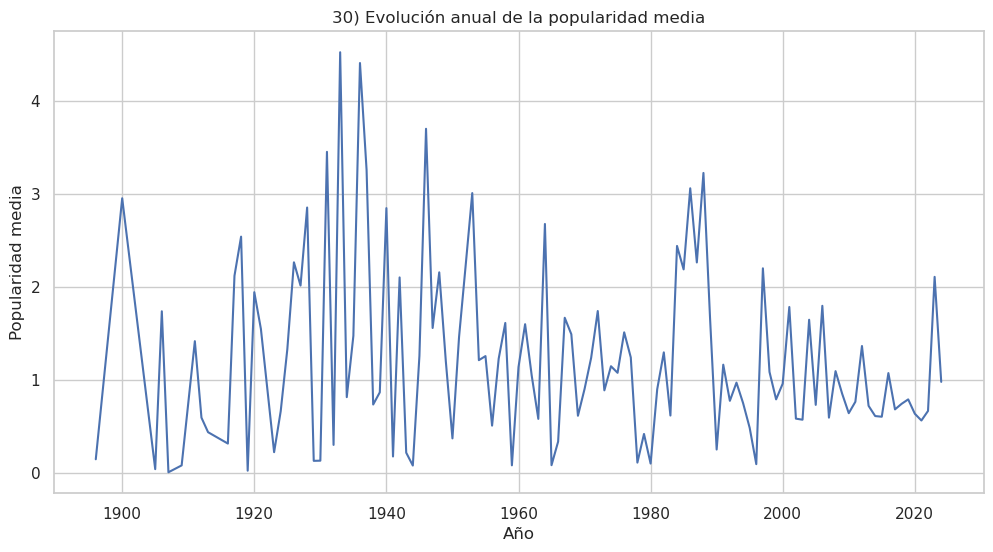

In [44]:
# 30. Evolución anual de la popularidad media
fig_30 = plt.figure(figsize=(12,6))
pop_year = df.groupby(col_release_year)['popularity'].mean().sort_index()
pop_year.plot()
plt.xlabel('Año')
plt.ylabel('Popularidad media')
plt.title('30) Evolución anual de la popularidad media')
plt.grid(True)
plt.show()